In [11]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import serial
import sklearn as sks
import cv2
import matplotlib.pyplot as plt

In [12]:
# read image
img = cv2.imread('IMG_0014.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape


(804, 1082, 3)

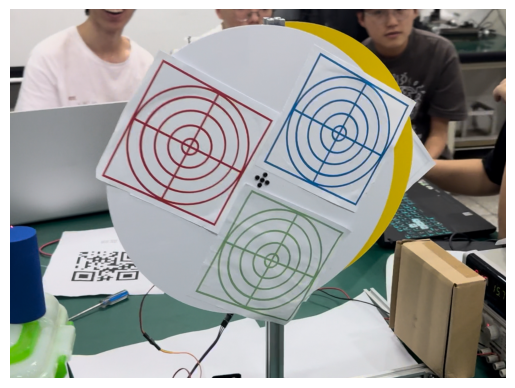

In [13]:
plt.imshow(img)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [14]:
# convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [15]:
# apply red mask
lower_red = np.array([166,65,73])
upper_red = np.array([177,173,134])
red_mask = cv2.inRange(hsv, lower_red, upper_red)


In [16]:
red_mask = cv2.GaussianBlur(red_mask, (3,3), 2)
# red_mask = cv2.medianBlur(red_mask, 5)


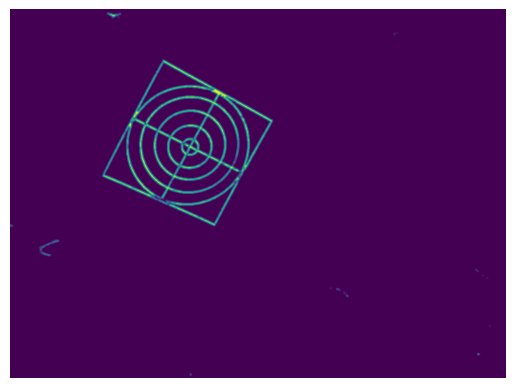

In [17]:
plt.imshow(red_mask)
plt.axis('off')
plt.show()

In [18]:
# 检测圆
red_circles = cv2.HoughCircles(red_mask, 
                           cv2.HOUGH_GRADIENT, 
                           dp=1, 
                           minDist=100,
                           param1=50+5,
                           param2=30+22,
                           minRadius=0,
                           maxRadius=0)

In [19]:
if red_circles is not None:
    red_circles = np.uint16(np.around(red_circles))
    for i in red_circles[0, :]:
        red_center = (i[0], i[1])  # 圆心
        red_radius = i[2]          # 圆半径
        cv2.circle(img, red_center, red_radius, (255, 0, 0), 3)  # 画圆
        cv2.circle(img, red_center, 2, (0, 255, 0), 3)       # 画圆心

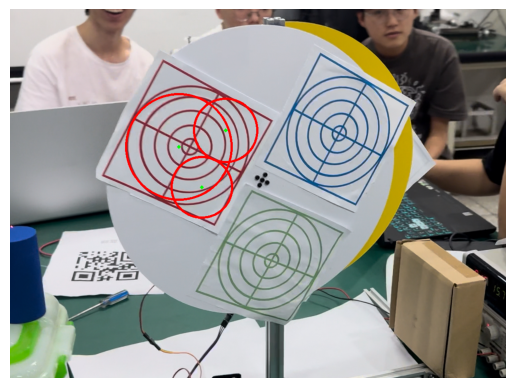

In [20]:
plt.imshow(img)
plt.axis('off')
plt.show()